# Analyzing Data with Spark

William Templer, Vincent Aubriot

##  Overview

This notebook contains our analysis proposition for the LSDM project, that focuses on a dataset published by Google that contains activity and configuration information for 12.5 thousands servers, over a long activity period (29 days).

During our study, we first focused on basic questions, in order to extract useful metrics and get used to how Spark works and what functions we can use to complete each task. Then, we proposed an extension.

## Basic analysis

We start by importing useful librairies, and launching pyspark.

In [1]:
import seaborn as sns
import matplotlib.pyplot as plt
colors = sns.color_palette('viridis')

import numpy as np
np.set_printoptions(suppress=True)

from pyspark import SparkContext
from lib.table import Table

# start spark with 1 worker thread
sc = SparkContext("local[*]")
sc.setLogLevel("ERROR")

In [2]:
plt.rcParams['figure.figsize'] = [12, 8]
plt.rcParams['figure.dpi'] = 100 # 200 e.g. is really fine, but slower

### What is the distribution of the machines according to their CPU capacity?

We first load the "machine events" file, as it contains information about all of the machine available in the system.
The goal is to count all occurences of each value recorded for the cpu, and from this, to output the global distribution of the CPU capacity for the entire system.

To load the file, we use a custom class which, from a given file, creates a RDD using the current spark context.
A partial output is done to confirm that we indeed have the information we need.

In [3]:
machine_events = Table('machine_events', sc)
machine_events.pprint(take=5)

,time,machine_id,event_type,platform_id,cpus,memory
0,0,5,0,HofLGzk1Or/8Ildj2+Lqv0UGGvY82NLoni8+J/Yy0RU=,0.5,0.2493
1,0,6,0,HofLGzk1Or/8Ildj2+Lqv0UGGvY82NLoni8+J/Yy0RU=,0.5,0.2493
2,0,7,0,HofLGzk1Or/8Ildj2+Lqv0UGGvY82NLoni8+J/Yy0RU=,0.5,0.2493
3,0,10,0,HofLGzk1Or/8Ildj2+Lqv0UGGvY82NLoni8+J/Yy0RU=,0.5,0.2493
4,0,13,0,HofLGzk1Or/8Ildj2+Lqv0UGGvY82NLoni8+J/Yy0RU=,0.5,0.2493


We could confirm that the output contains the cpus property that interests us for each machine. We now compute the global distribution, and we visualize it as a pie chart.

In [4]:
cpu_dist = machine_events.select(['cpus']).countByValue()
for cpu_type, value in cpu_dist.items():
    print(f'cpu type: {cpu_type[0]}, count: {value}')

cpu type: 0.5, count: 35015
cpu type: 0.25, count: 510
cpu type: 1, count: 2223
cpu type: NA, count: 32


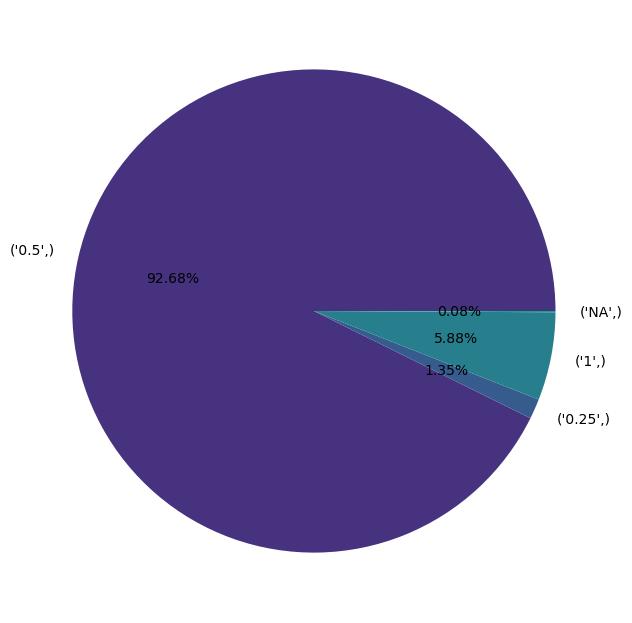

In [5]:
plt.pie(cpu_dist.values(), labels=cpu_dist.keys(), colors = colors, autopct='%.2f%%')
plt.show()

From the visualization shown above, we see that a large majority of the machines used has an "average" CPU.

### On average, how many tasks compose a job?

Now, we focus on the jobs that were running during the analyzed period. We know that each job is composed of multiple tasks, but no information was provided about the average number of tasks in a single job. In order to compute it by hand, we load the task_events table, that lists for every task that was ever executed at the time @various information, like the job to which the task is associated, the user that requested to execute the task, the priority, and the resources it requested to be able to process the calculations and terminate.

In [6]:
task_events = Table('task_events', sc)
task_events.pprint(3)

,time,missing_info,job_id,task_index,machine_id,event_type,user,scheduling_class,priority,cpu_request,memory_request,disk_space_request,different_machines_restriction
0,0,2,3418309,0,4155527081,0,70s3v5qRyCO/1PCdI6fVXnrW8FU/w+5CKRSa72xgcIo=,3,9,NA,NA,NA,NA
1,0,2,3418309,1,329150663,0,70s3v5qRyCO/1PCdI6fVXnrW8FU/w+5CKRSa72xgcIo=,3,9,NA,NA,NA,NA
2,0,NA,3418314,0,3938719206,0,70s3v5qRyCO/1PCdI6fVXnrW8FU/w+5CKRSa72xgcIo=,3,9,0.125,0.07446,0.0004244,0


Now that we have the table, we want to count for each job the associated number of tasks, and output useful metrics.

In [7]:

job = task_events.select(['job_id'])
task_per_job = list(job.countByValue().values())

mean = round(np.mean(task_per_job))
std = round(np.std(task_per_job))

print(f"A job can have between {np.min(task_per_job)} and {np.max(task_per_job)} tasks.")

low_mean = mean - std if (mean - std >= np.min(task_per_job)) else np.min(task_per_job)
high_mean = mean + std if (mean + std <= np.max(task_per_job)) else np.max(task_per_job)
print(f"In average, a job will have between {low_mean} and {high_mean} tasks, because the mean number of tasks in a job is equal to {mean} , and the standard deviation is equal to {std} ")

A job can have between 1 and 46037 tasks.
In average, a job will have between 1 and 936 tasks, because the mean number of tasks in a job is equal to 92 , and the standard deviation is equal to 844 


## What is the distribution of the number of jobs/tasks per scheduling class?

Each job and task possess a scheduling class, represented by a number between 0 and 3, that represents the sensibility to latency of the process. The higher the number is, the more the process is sensitive to latency (i.e., the process is a critical job that generates revenue...). This classification is used to affect the resource access policy on the local machine that executes the impacted process, and processes on the higher end of the classification tend to have higer priorities.

We would like to check the distribution of tasks and jobs for each class, in order to see what kind of processes these machines were treating the most.

In [8]:
## Version 1: bad
def to_list(a):
    return [[a[0]], [a[1]]]

def append(a, b):
    a[0].append(b[0])
    a[1].append(b[1])
    return [a[0], a[1]]

def extend(a, b):
    a[0].extend(b[0])
    a[1].extend(b[1])
    return [a[0], a[1]]

We select the job id and the scheduling class for each task. Then, we do a combination by key, in order to count the number of unique tasks and unique jobs that were attributed to each scheduling class. This implies to define our own initialization, merging and combination functions used to manage the set of jobs and tasks associated to one particular scheduling class.

In [9]:
def init(new):
    job = set()
    job.add(new)
    return [job, 1]

def merge(old, new):
    old[0].add(new)
    return [old[0], old[1] + 1]

def combine(c1, c2):
    c1[0].union(c2[0])
    return [c1[0], c1[1]+c2[1]]

In [10]:
job_task_sched = task_events.select(['scheduling_class','job_id'])
res = job_task_sched.combineByKey(init, merge, combine).mapValues(lambda x: (len(x[0]), x[1]))
print('\n'.join(f'scheduling class [{s}], #job: {j}, #task: {t}' for \
            s, (j,t) in res.collect()))

scheduling class [1], #job: 1253, #task: 58109
scheduling class [0], #job: 580, #task: 237969
scheduling class [3], #job: 922, #task: 56586
scheduling class [2], #job: 1226, #task: 97482


We quickly see that most of the tasks were not really sensitive to latency, but surprisingly, most jobs actually were at least a little sensitive.

### Do tasks with low priority have a higher probability of being evicted?

Let's focus on the priority system. We wish to know if tasks having a low priority have a higher risk of being evicted in order to make place for the "more important" processses.

In [11]:
rdd = task_events.select(['event_type', 'priority'])\
        .filter(lambda x: x[0] == '2')\
        .map(lambda x: int(x[1]))

total_evicted = rdd.count()
p = rdd.countByValue()
for k,v in sorted(p.items()):
    print(f'priority [{k}] = {round(v/total_evicted, 4)}')

priority [0] = 0.97
priority [1] = 0.012
priority [2] = 0.0127
priority [9] = 0.0051
priority [10] = 0.0002


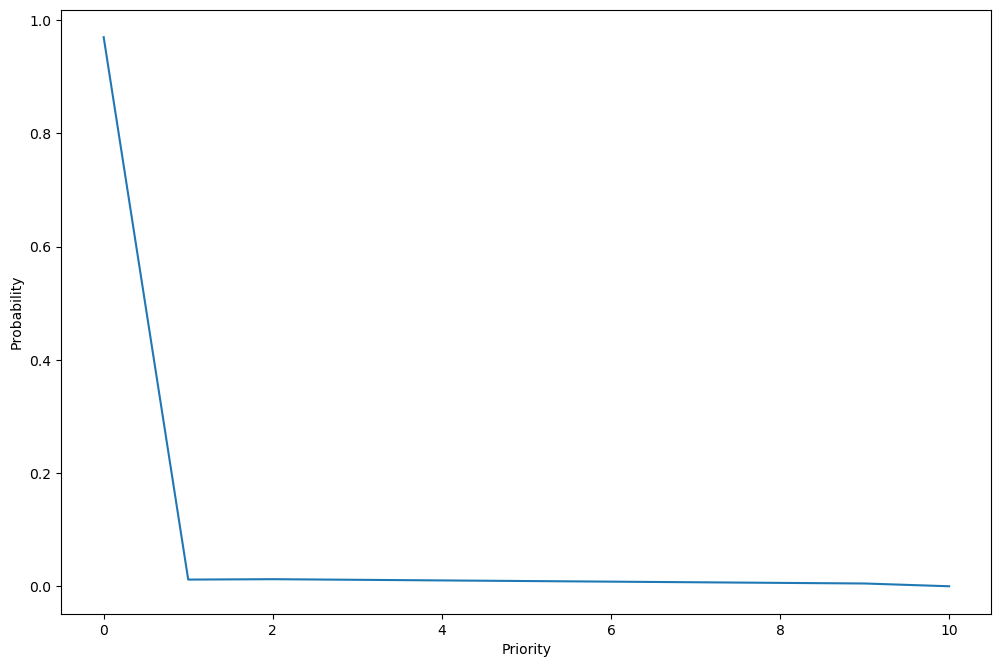

In [12]:
sp = sorted(p.items())
keys = [v[0] for v in sp]
values = [round(v[1]/total_evicted, 4) for v in sp]

plt.plot(keys, values, linestyle='solid')
plt.xlabel('Priority')
plt.ylabel('Probability')
plt.show()

Indeed, lower-priority processes have a 97%-chance of being evicted at any time to give way to more important processes. However, this probability drops to 1% and less as soon as the priority is equal to or above 1. 

### In general, do tasks from the same job run on the same machine?

In [13]:
task_events.select(['job_id', 'machine_id'])\
           .groupByKey()\
           .mapValues(lambda x: len(set(x)))\
           .sortBy(lambda x: x[1], ascending=False)\
           .take(5)

[('6221861800', 10093),
 ('6225099547', 4104),
 ('5402488769', 4051),
 ('2902878580', 3881),
 ('6238340468', 3067)]

### Are the tasks that request the more resources the one that consume the more resources?

To anwser this question, we need to rely on the "task_usage" logs. It holds, for each task, details about its execution, such as the start and end time, as well as the resources assigned to the task and the ones that were effectively consumed by the task.

Let's start by loading this table as a RDD.

In [14]:
task_usage = Table('task_usage', spark_context=sc)
task_usage.pprint(5)

,start_time,end_time,job_id,task_index,machine_id,cpu_rate,canonical_memory_usage,assigned_memory_usage,unmapped_page_cache,total_page_cache,maximum_memory_usage,disk_i/o_time,local_disk_space_usage,maximum_cpu_rate,maximum_disk_io_time,cycles_per_instruction,memory_accesses_per_instruction,sample_portion,aggregation_type,sampled_cpu_usage
0,600000000,900000000,3418309,0,4155527081,0.001562,0.06787,0.07568,0.001156,0.001503,0.06787,2.861e-06,0.0001869,0.03967,0.0003567,2.445,0.007243,0,1,0
1,600000000,900000000,3418309,1,329150663,0.001568,0.06787,0.07556,0.0003195,0.0007,0.06787,5.722e-06,0.0001879,0.03302,0.0009289,2.1,0.005791,0,1,0
2,600000000,900000000,3418314,0,3938719206,0.0003071,0.08044,0.09521,0.0002823,0.0006704,0.08044,4.768e-06,0.0001841,0.02377,0.0007858,5.588,0.0208,0,1,0
3,600000000,900000000,3418314,1,351618647,0.0003004,0.08044,0.09521,0.0005369,0.0008698,0.08044,9.537e-06,0.0001831,0.007919,0.002285,5.198,0.02038,0,1,0
4,600000000,900000000,3418319,0,431052910,0.0004606,0.07715,0.0874,0.0006247,0.0008516,0.07715,1.907e-06,0.0002041,0.005112,0.0002146,2.937,0.009449,0,1,0


### CPU usage

We start by studying the CPU usage. A good analysis would be to compare for each job and task the CPU quota requested by the process with the CPU that was actually used.

We first take the CPU request for each job and task:

In [15]:
cpu_req = task_events.select(['job_id','task_index','cpu_request'])\
                     .filter(lambda x: x[2] != 'NA')\
                     .map(lambda x: ((x[0],x[1]),float(x[2])))
cpu_req.take(5)

[(('3418314', '0'), 0.125),
 (('3418314', '1'), 0.125),
 (('3418368', '0'), 0.03125),
 (('3418368', '1'), 0.03125),
 (('3418368', '2'), 0.03125)]

We then get the CPU rates that were indeed used by each job and task:

In [16]:
cpu_us = task_usage.select(['job_id','task_index','cpu_rate'])\
                   .filter(lambda x: x[2] != 'NA')\
                   .map(lambda x: ((x[0],x[1]),float(x[2])))
cpu_us.take(5)

[(('3418309', '0'), 0.001562),
 (('3418309', '1'), 0.001568),
 (('3418314', '0'), 0.0003071),
 (('3418314', '1'), 0.0003004),
 (('3418319', '0'), 0.0004606)]

Finally, we do a join operation to link the requests and usages in a single data structure.

In [17]:
cpu_cons = cpu_req.join(cpu_us)
cpu_cons.take(5)

[(('17109330', '5'), (0.0625, 0.03589)),
 (('17109330', '5'), (0.0625, 0.03528)),
 (('17109330', '5'), (0.0625, 0.03662)),
 (('17109330', '5'), (0.0625, 0.03351)),
 (('17109330', '5'), (0.0625, 0.03339))]

From the joined structure, we do a combine by key to find, for each job and task, each CPU request done and the CPU that was indeed used at the time.

In [18]:
def avg_init(row):
    return (row[0], row[1], 1)

def avg_merge(old, new):
    return (old[0]+new[0],old[1]+new[1],old[2]+1)

def avg_cmb(old, new):
    return (old[0]+new[0],old[1]+new[1],old[2]+new[2])

cpu_cons_avg = cpu_cons.combineByKey(avg_init,avg_merge, avg_cmb)
cpu_cons_avg.take(10)

[(('17109330', '5'), (2.125, 1.21388, 34)),
 (('17109330', '11'), (2.125, 1.0815, 34)),
 (('17109330', '15'), (2.125, 1.2545199999999999, 34)),
 (('17109330', '31'), (2.125, 1.2263199999999999, 34)),
 (('17109330', '36'), (2.125, 1.53612, 34)),
 (('17109330', '49'), (2.125, 1.0648, 34)),
 (('17109330', '75'), (2.125, 1.1832200000000002, 34)),
 (('17109330', '92'), (2.125, 1.21472, 34)),
 (('17109330', '101'), (2.125, 1.1731200000000002, 34)),
 (('17109330', '109'), (2.125, 1.0849, 34))]

Finally, we compute the average of all CPU requests and CPU usages for all tasks.

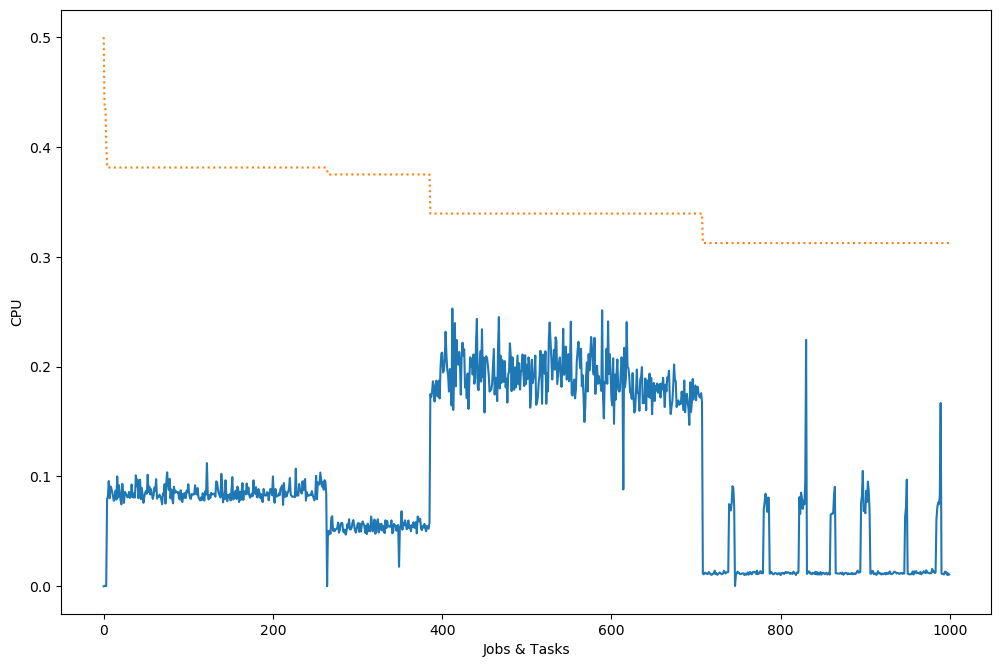

In [19]:
final = cpu_cons_avg.mapValues(lambda x: (x[0]/x[2],x[1]/x[2])).sortBy(lambda x: x[1][0], ascending=False).take(1000)

keys = []
i = 0
for k in final:
    keys.append(i)
    i += 1
req = [v[1][0] for v in final]
real = [v[1][1] for v in final]

plt.plot(keys, real, linestyle='solid')
plt.plot(keys, req, linestyle='dotted')
plt.xlabel('Jobs & Tasks')
plt.ylabel('CPU')
plt.show()

Above is a graph showing the CPU capacity requested by the top 1000 Jobs and the CPU capacity that they have really consumed. As we can see, the most self-declared gluttonous are not ofteh the ones that are really consuming the most, as they only use a small fraction of what's available.

### Memory request

We now focus on memory (RAM) requests and real usage. The metrics that will be used are memory_request and canonical_memory_usage.
The process mostly remains the same as for the CPU.

In [20]:
mem_req = task_events.select(['job_id','task_index','memory_request'])\
                     .filter(lambda x: x[2] != 'NA')\
                     .map(lambda x: ((x[0],x[1]),float(x[2])))
mem_us = task_usage.select(['job_id','task_index','canonical_memory_usage'])\
                   .filter(lambda x: x[2] != 'NA')\
                   .map(lambda x: ((x[0],x[1]),float(x[2])))
mem_cons = mem_req.join(mem_us)
mem_cons_avg = mem_cons.combineByKey(avg_init,avg_merge, avg_cmb)\
                       .mapValues(lambda x: (x[0]/x[2],x[1]/x[2]))\
                       .sortBy(lambda x: x[1][0], ascending=False)
mem_cons_avg.take(10)

[(('6024393894', '0'), (0.9551000000000007, 0.7519999999999998)),
 (('6024393894', '1'), (0.9551000000000007, 0.7519999999999998)),
 (('6184967406', '2'), (0.6367000000000002, 0.5254)),
 (('6184967406', '1'), (0.6367000000000002, 0.5812588235294115)),
 (('4472621957', '0'), (0.6367000000000002, 0.5527000000000001)),
 (('6184967406', '0'), (0.6367000000000002, 0.5944882352941174)),
 (('6184967359', '0'), (0.6367000000000002, 0.5605882352941174)),
 (('6088049389', '0'), (0.5098, 0.0012228823529411767)),
 (('5840251953', '0'), (0.5088000000000004, 0.4160294117647058)),
 (('259235987', '0'), (0.5088000000000004, 0.2930235294117647))]

## Can we observe correlations between peaks of high resource consumption on some machines and task eviction events?

The objective of this last analysis is to verify if consuming too much resources could lead a task to be evicted in favour of another one that is less glutoneous.

In [21]:
task_usage.pprint(5)

,start_time,end_time,job_id,task_index,machine_id,cpu_rate,canonical_memory_usage,assigned_memory_usage,unmapped_page_cache,total_page_cache,maximum_memory_usage,disk_i/o_time,local_disk_space_usage,maximum_cpu_rate,maximum_disk_io_time,cycles_per_instruction,memory_accesses_per_instruction,sample_portion,aggregation_type,sampled_cpu_usage
0,600000000,900000000,3418309,0,4155527081,0.001562,0.06787,0.07568,0.001156,0.001503,0.06787,2.861e-06,0.0001869,0.03967,0.0003567,2.445,0.007243,0,1,0
1,600000000,900000000,3418309,1,329150663,0.001568,0.06787,0.07556,0.0003195,0.0007,0.06787,5.722e-06,0.0001879,0.03302,0.0009289,2.1,0.005791,0,1,0
2,600000000,900000000,3418314,0,3938719206,0.0003071,0.08044,0.09521,0.0002823,0.0006704,0.08044,4.768e-06,0.0001841,0.02377,0.0007858,5.588,0.0208,0,1,0
3,600000000,900000000,3418314,1,351618647,0.0003004,0.08044,0.09521,0.0005369,0.0008698,0.08044,9.537e-06,0.0001831,0.007919,0.002285,5.198,0.02038,0,1,0
4,600000000,900000000,3418319,0,431052910,0.0004606,0.07715,0.0874,0.0006247,0.0008516,0.07715,1.907e-06,0.0002041,0.005112,0.0002146,2.937,0.009449,0,1,0


In [22]:
max_cpu_task = task_usage.select(['job_id', 'maximum_cpu_rate'])\
                         .mapValues(lambda x: float(x))\
                         .reduceByKey(max)

In [23]:
from pyspark.sql import SparkSession
spark = SparkSession(sc)

te = task_events.select(['job_id', 'event_type'])
max_cpu_evt = te.join(max_cpu_task).map(lambda x: (int(x[1][0]), x[1][1])).collect()

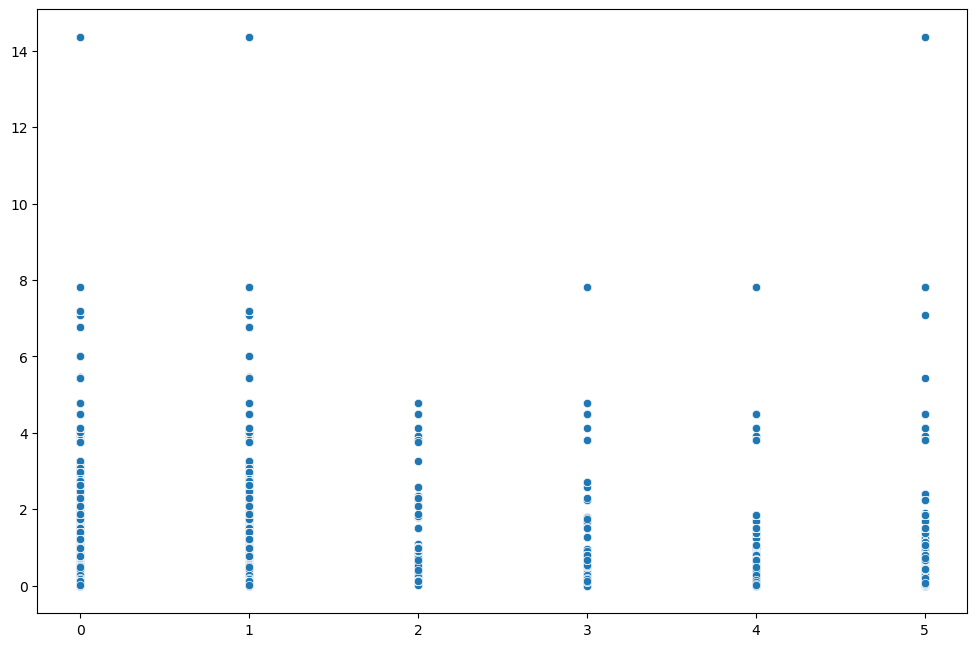

In [24]:
sns.scatterplot(x=[x[0] for x in max_cpu_evt], y=[x[1] for x in max_cpu_evt])

### Does the number of constraints of a task (including different-machine constraint) have an impact on the amount of time it spends in the PENDING state.

In [53]:
# Select first SUBMIT transition for each job
submit_status = task_events.select(['job_id','task_index','event_type', 'time'])\
    .filter(lambda x: x[2] in ['0'])

from pyspark.sql.window import Window
from pyspark.sql.functions import rank, col

df = spark.createDataFrame(submit_status, ['job_id','task_index','event_type', 'time']).withColumnRenamed('time', 'time_start_pending')

cols = ['job_id', 'task_index']
window = Window.partitionBy([col(x) for x in cols]).orderBy(df['time_start_pending'])

inpending = df.select('*', rank().over(window).alias('rank'))\
  .filter(col('rank') == 1)\

inpending.show()

+----------+----------+----------+------------------+----+
|    job_id|task_index|event_type|time_start_pending|rank|
+----------+----------+----------+------------------+----+
|1005190908|         1|         0|                 0|   1|
|1005190908|         5|         0|                 0|   1|
|1005190908|         6|         0|                 0|   1|
|1005190908|         9|         0|                 0|   1|
|1005831088|         0|         0|                 0|   1|
|1005831090|        12|         0|                 0|   1|
|1005831090|        13|         0|                 0|   1|
|1005831090|        18|         0|                 0|   1|
|1005831090|        20|         0|                 0|   1|
|1005831090|        24|         0|                 0|   1|
|1005831090|        25|         0|                 0|   1|
|1005831090|         3|         0|                 0|   1|
|1005831090|        35|         0|                 0|   1|
|1005831090|        37|         0|                 0|   

In [55]:
# Select first SCHEDULE, FAIL, KILL or LOST transition for each job (meaning that our task got out of PENDING)
outpending_status = task_events.select(['job_id','task_index','event_type', 'time'])\
    .filter(lambda x: x[2] in ['1', '3', '5', '6'])

df = spark.createDataFrame(outpending_status, ['job_id','task_index','event_type', 'time']).withColumnRenamed('time', 'time_end_pending')

window = Window.partitionBy([col(x) for x in cols]).orderBy(df['time_end_pending'])

outpending = df.select('*', rank().over(window).alias('rank'))\
  .filter(col('rank') == 1)

outpending.show()

+----------+----------+----------+----------------+----+
|    job_id|task_index|event_type|time_end_pending|rank|
+----------+----------+----------+----------------+----+
|1005190908|         1|         1|               0|   1|
|1005190908|         5|         1|               0|   1|
|1005190908|         6|         1|               0|   1|
|1005190908|         9|         1|               0|   1|
|1005831088|         0|         1|               0|   1|
|1005831090|        12|         1|               0|   1|
|1005831090|        13|         1|               0|   1|
|1005831090|        18|         1|               0|   1|
|1005831090|        20|         1|               0|   1|
|1005831090|        24|         1|               0|   1|
|1005831090|        25|         1|               0|   1|
|1005831090|         3|         1|               0|   1|
|1005831090|        35|         1|               0|   1|
|1005831090|        37|         1|               0|   1|
|1005831090|        39|        

In [65]:
full = inpending.join(outpending, ['job_id', 'task_index'])
full = full.withColumn('delta_time', col('time_end_pending') - col('time_start_pending'))
full.filter(col('delta_time') > 0).show()

+----------+----------+----------+------------------+----+----------+----------------+----+-------------+
|    job_id|task_index|event_type|time_start_pending|rank|event_type|time_end_pending|rank|   delta_time|
+----------+----------+----------+------------------+----+----------+----------------+----+-------------+
| 515042969|         1|         0|                 0|   1|         5|      1026166412|   1|1.026166412E9|
|5495698530|         0|         0|        2229680005|   1|         1|      2231738115|   1|    2058110.0|
|5495698530|         1|         0|        2229680007|   1|         1|      2231738172|   1|    2058165.0|
|5664371117|       369|         0|                 0|   1|         1|      2450274015|   1|2.450274015E9|
|5664371117|       475|         0|                 0|   1|         1|      4475973764|   1|4.475973764E9|
|6218406404|      1006|         0|                 0|   1|         1|      1736168175|   1|1.736168175E9|
|6218406404|      1010|         0|            

In [103]:
task_constraints = Table('task_constraints', spark_context=sc)

# Counts nb of constraints registered for each (job, task)
tc = task_constraints.select(['job_id', 'task_index', 'time']).map(lambda x: ((x[0],x[1]), x[2]))
tc.take(10)

[(('3418314', '0'), '0'),
 (('3418314', '0'), '0'),
 (('3418314', '1'), '0'),
 (('3418314', '1'), '0'),
 (('3418368', '0'), '0'),
 (('3418368', '0'), '0'),
 (('3418368', '1'), '0'),
 (('3418368', '1'), '0'),
 (('3418368', '2'), '0'),
 (('3418368', '2'), '0')]

In [127]:
def avg_init(row):
    return [1]

def avg_merge(old, new):
    return [old[0]+1]

def avg_cmb(old, new):
    return [old[0]+new[0]]

res = tc.combineByKey(avg_init, avg_merge, avg_cmb).map(lambda x: (x[0][0], x[0][1], x[1][0]))

cNames = ["job_id", "task_index", "nb_constraints"]
asdf = res.toDF(cNames)

asdf.show()

+--------+----------+--------------+
|  job_id|task_index|nb_constraints|
+--------+----------+--------------+
| 3418368|         2|             4|
| 3418380|         0|             4|
| 3418380|         1|             4|
| 3418400|         0|             4|
| 3418400|         1|             4|
| 3418405|         0|             4|
| 3418405|         1|             4|
| 6590371|         0|             4|
| 6590371|         1|             4|
| 6590376|         0|             4|
| 6590376|         1|             4|
| 6724949|         0|             4|
| 6724949|         1|             4|
| 7053513|         2|             4|
|17109330|         2|             5|
|17109330|         3|             5|
|17109330|         5|             5|
|17109330|         6|             5|
|17109330|         7|             5|
|17109330|        11|             5|
+--------+----------+--------------+
only showing top 20 rows



In [128]:
full2 = full.join(asdf, ['job_id', 'task_index'])
full2.filter(col('delta_time') > 0).show()

+----------+----------+----------+------------------+----+----------+----------------+----+-------------+--------------+
|    job_id|task_index|event_type|time_start_pending|rank|event_type|time_end_pending|rank|   delta_time|nb_constraints|
+----------+----------+----------+------------------+----+----------+----------------+----+-------------+--------------+
| 515042969|         1|         0|                 0|   1|         5|      1026166412|   1|1.026166412E9|          1614|
|6251625636|        10|         0|        2430254352|   1|         1|      2450274212|   1|   2.001986E7|             2|
|6251625636|       106|         0|        2430254448|   1|         1|      2460156572|   1|  2.9902124E7|             2|
|6251625636|       107|         0|        2430254449|   1|         1|      2464484814|   1|  3.4230365E7|             2|
|6251625636|       113|         0|        2430254455|   1|         1|      2448580154|   1|  1.8325699E7|             2|
|6251625636|       114|         

In [ ]:
# @ME : VIS GOES HERE, USE 2 LAST COLS